In [2]:
import numpy as np
import pandas as pd
import networkx as nx
#import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import collections
import scipy
import operator
from functools import reduce
import community as cmt
from networkx.algorithms.community import greedy_modularity_communities
import seaborn as sns
from sklearn.mixture import GaussianMixture as GMM
import random
sns.set(rc={'figure.figsize':(16,9)})
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

/home/liangwei/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/liangwei/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/liangwei/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# 1. Load cleaned dataset

In [80]:
routes = pd.read_csv("./data/routes_cleaned.csv")
airports = pd.read_csv("./data/airports_cleaned.csv")

In [9]:
# Load routes with distance
dists_df = pd.read_csv("./data/dists.csv")

# 2. Create network

In [7]:
routes.head()

,Unnamed: 0,airline,airline_id,source_airport,source_airport_id,destination_airport,destination_airport_id,codeshare,stops,equipment
0,0,2B,410,AER,2965,KZN,2990,NaN,0,CR2
1,1,2B,410,ASF,2966,KZN,2990,NaN,0,CR2
2,2,2B,410,ASF,2966,MRV,2962,NaN,0,CR2
3,3,2B,410,CEK,2968,KZN,2990,NaN,0,CR2
4,4,2B,410,CEK,2968,OVB,4078,NaN,0,CR2


In [8]:
airports.head()

,Unnamed: 0,airport_id,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,TzDatabase,Type,Source
0,0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10,U,Pacific/Port_Moresby,airport,OurAirports
1,1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10,U,Pacific/Port_Moresby,airport,OurAirports
2,2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10,U,Pacific/Port_Moresby,airport,OurAirports
3,3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10,U,Pacific/Port_Moresby,airport,OurAirports
4,4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10,U,Pacific/Port_Moresby,airport,OurAirports


In [12]:
dists_df.head()

,source_airport_id,destination_airport_id,Latitude_src,Longitude_src,Latitude_dst,Longitude_dst,distance
0,2965,2990,43.449902,39.956600,55.606201,49.278702,1507.989680
1,2966,2990,46.283298,48.006302,55.606201,49.278702,1040.943207
2,2968,2990,55.305801,61.503300,55.606201,49.278702,773.126239
3,4029,2990,55.408798,37.906300,55.606201,49.278702,718.084202
4,6156,2990,50.643799,36.590099,55.606201,49.278702,1010.815885


In [14]:
# Create graph from distances dataframe
G = nx.from_pandas_edgelist(dists_df, 
                            "source_airport_id",
                           "destination_airport_id",
                           ["distance"])

# 3. Explore network attributes

Statistics to explore
- average degree
- connected components
- diameter 
- centrality measures
- eigenvector centrality
- page rank 

## 3.1 Degree distribution

In [32]:
# Get degree count
degree_list = sorted([d for n, d in G.degree()], reverse = True)
degree_count = collections.Counter(degree_list)
deg, cnt = zip(*degree_count.items())

Text(20, 480, 'Mean = 11.73')

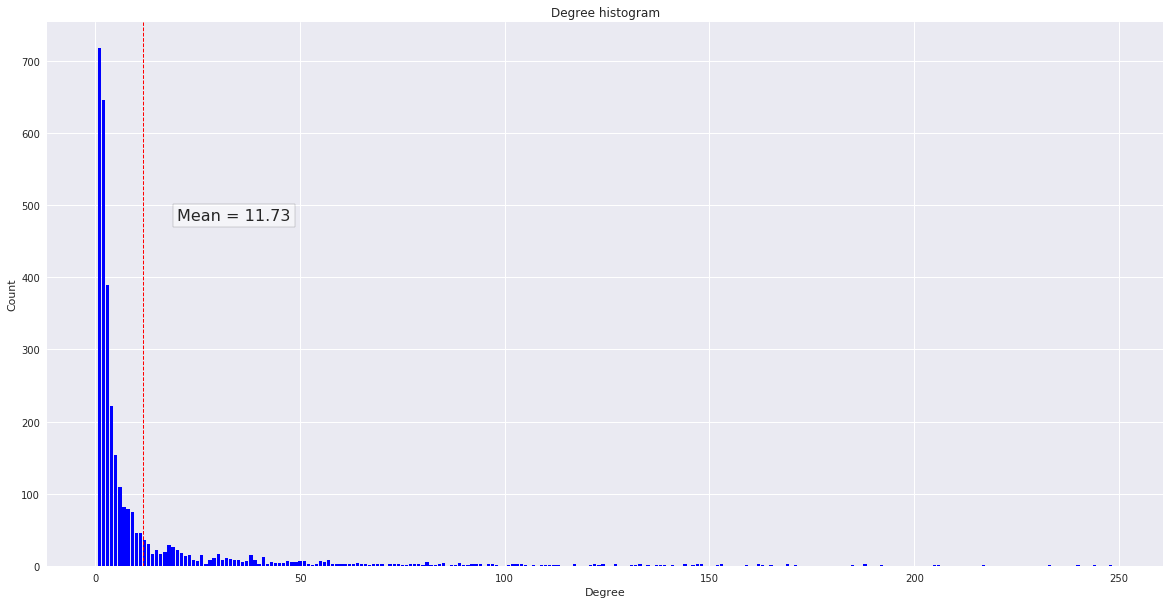

In [711]:
# Plot degree distribution
fig = plt.figure(figsize = (20, 10))
ax = fig.add_subplot(111)
ax.bar(deg, cnt, width = 0.8, color = "b")
deg_mean = np.mean(degree_list)
ax.axvline(deg_mean, color = "r",
            linestyle = "dashed",
           linewidth = 1)
ax.set_title("Degree histogram")
ax.set_xlabel("Degree")
ax.set_ylabel("Count")
ax.text(20, 480, "Mean = {:.2f}".format(deg_mean),
        bbox=dict(facecolor='white',
                  alpha=0.5), fontsize=16)

Notice that the degree follows power law distribution. This fact indicates that the network is indeed scale free.

## 3.2 Connected components

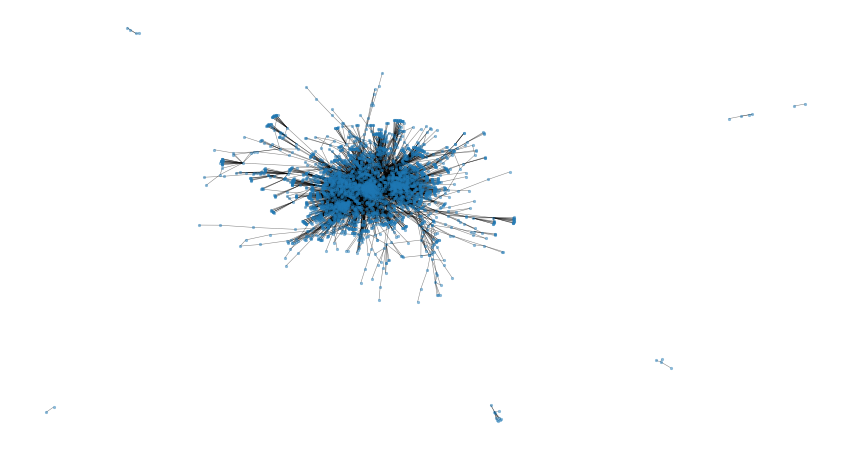

In [252]:
# Visualize the components
fig = plt.figure(figsize = (15, 8))
ax = fig.add_subplot(111)
nx.draw_networkx(G, ax = ax, node_size = 8,
                alpha = 0.5, width = 0.5, 
                with_labels = False)
ax.set_axis_off()

In [696]:
print(f"Number of connected components is {nx.number_connected_components(G)}")

Number of connected components is 7


In [55]:
# Get the largest connected components
largest_cc = max(nx.connected_component_subgraphs(G), key = len)

In [704]:
print(f"The largest connected component contains {'{:.2%}'.format(len(largest_cc.nodes()) / len(G.nodes()))}\
 nodes")

The largest connected component contains 99.19% nodes


For the remaining parts we continue with the largest connected component.

## 3.3 Giant component diameter

The diameter represents the largest number of intermediate edges between two arbitray nodes in the giant components.

In [705]:
# Get the unweighted diameter of the graph
print(f"The largest connected component has diameter {nx.diameter(largest_cc)}")

The largest connected component has diameter 12


## 3.4 Clustering coefficient

In [57]:
# Get the avg clustering coefficient of the graph
# The larger the value is, the denser the graph is.
nx.average_clustering(largest_cc)

0.4928300852568963

## 3.5 Centrality

In [116]:
from IPython.display import display

In [237]:
# Define number of airports to display in results
K = 10

In [182]:
def visualize_centrality(centrality, k, centrality_type):
    """
    Show top k airports with respect to centrality
    Visualize their centrality values
    @param centrality (dict): centrality mapping
    @param k (int): number of results to be visualized
    """
    
    # Get top k airport ids
    airport_ids = [key for key, _ in sorted(centrality.items(), key = lambda item: item[1],
                                           reverse = True)[: k]]
    # Get their corresponding centrality values
    top_centrality = [centrality[key] for key in airport_ids]
    
    # Print the top k airports' data
    print(f"Top {k} {centrality_type} airports are")
    freq_airports = airports[["airport_id", "Name", "IATA", "City", "Country", "TzDatabase"]].copy()
    freq_airports.reset_index()
    freq_airports.set_index("airport_id", inplace = True)
    freq_airports = freq_airports.loc[airport_ids]
    display(freq_airports[["Name", "IATA", "City", "Country", "TzDatabase"]])
    
    # Visualize the top k airports' centrality value
    fig = plt.figure(figsize = (10, 5))
    ax = fig.add_subplot(111)
    freq_airport_abbre = freq_airports["IATA"].values
    ax.bar(range(k),top_centrality)
    ax.set_xticks(range(k))
    ax.set_xticklabels(freq_airport_abbre)
    ax.set_title(f"Top {k} {centrality_type} airports")
    ax.set_xlabel("IATA")
    ax.set_ylabel("Centrality")

### 3.5.1 Betweenness centrality

In [150]:
# Get the betweeness centrality
betweenness = nx.betweenness_centrality(largest_cc)

Top 10 betweenness centrality airports are


,Name,IATA,City,Country,TzDatabase
airport_id,,,,,
1382,Charles de Gaulle International Airport,CDG,Paris,France,Europe/Paris
3484,Los Angeles International Airport,LAX,Los Angeles,United States,America/Los_Angeles
3774,Ted Stevens Anchorage International Airport,ANC,Anchorage,United States,America/Anchorage
2188,Dubai International Airport,DXB,Dubai,United Arab Emirates,Asia/Dubai
340,Frankfurt am Main Airport,FRA,Frankfurt,Germany,Europe/Berlin
580,Amsterdam Airport Schiphol,AMS,Amsterdam,Netherlands,Europe/Amsterdam
3364,Beijing Capital International Airport,PEK,Beijing,China,Asia/Shanghai
3830,Chicago O'Hare International Airport,ORD,Chicago,United States,America/Chicago
193,Lester B. Pearson International Airport,YYZ,Toronto,Canada,America/Toronto


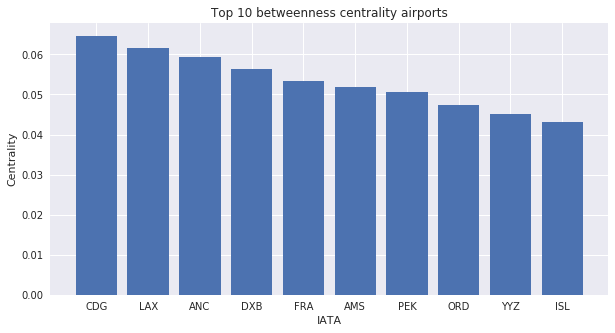

In [183]:
# Show the top 10 airports with highest betweenness centrality
visualize_centrality(betweenness, K, "betweenness centrality")

### 3.5.2 Eigen vector centrality

Top 10 eigenvalue centrality airports are


,Name,IATA,City,Country,TzDatabase
airport_id,,,,,
580,Amsterdam Airport Schiphol,AMS,Amsterdam,Netherlands,Europe/Amsterdam
340,Frankfurt am Main Airport,FRA,Frankfurt,Germany,Europe/Berlin
1382,Charles de Gaulle International Airport,CDG,Paris,France,Europe/Paris
346,Munich Airport,MUC,Munich,Germany,Europe/Berlin
1555,Leonardo da Vinci–Fiumicino Airport,FCO,Rome,Italy,Europe/Rome
507,London Heathrow Airport,LHR,London,United Kingdom,Europe/London
1701,Atatürk International Airport,ISL,Istanbul,Turkey,Europe/Istanbul
1218,Barcelona International Airport,BCN,Barcelona,Spain,Europe/Madrid
1678,Zürich Airport,ZRH,Zurich,Switzerland,Europe/Zurich


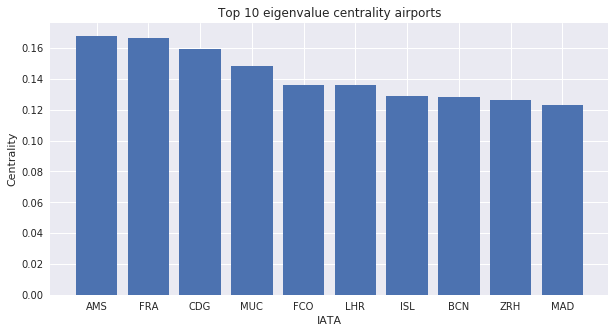

In [185]:
eigenvector_centrality = nx.eigenvector_centrality(largest_cc)
visualize_centrality(eigenvector_centrality, K, "eigenvalue centrality")

### 3.5.3 PageRank 

Top 10 pagerank airports are


,Name,IATA,City,Country,TzDatabase
airport_id,,,,,
3682,Hartsfield Jackson Atlanta International Airport,ATL,Atlanta,United States,America/New_York
3830,Chicago O'Hare International Airport,ORD,Chicago,United States,America/Chicago
1701,Atatürk International Airport,ISL,Istanbul,Turkey,Europe/Istanbul
3670,Dallas Fort Worth International Airport,DFW,Dallas-Fort Worth,United States,America/Chicago
3751,Denver International Airport,DEN,Denver,United States,America/Denver
1382,Charles de Gaulle International Airport,CDG,Paris,France,Europe/Paris
4029,Domodedovo International Airport,DME,Moscow,Russia,Europe/Moscow
580,Amsterdam Airport Schiphol,AMS,Amsterdam,Netherlands,Europe/Amsterdam
340,Frankfurt am Main Airport,FRA,Frankfurt,Germany,Europe/Berlin


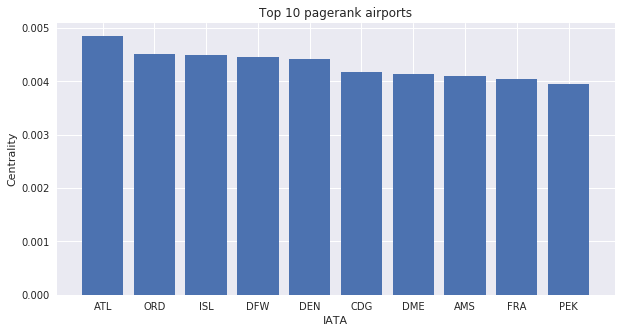

In [186]:
pagerank = nx.pagerank(largest_cc)
visualize_centrality(pagerank, K, "pagerank")

### 3.5.4 Summary of centrality

To eliminate the difference between variance of several measures, we take mean of ranks instead of centrality values of airports to produce the summary.

In [240]:
# Get order of each centrality measure
betweenness_ordered = dict(zip([k for k, _ in sorted(betweenness.items(),
                                                     key = lambda item: item[1],
                                                     reverse = True)],
                               range(1, len(betweenness) + 1)))

eigenvector_ordered = dict(zip([k for k, _ in sorted(eigenvector_centrality.items(),
                                                     key = lambda item: item[1],
                                                     reverse = True)],
                               range(1, len(eigenvector_centrality) + 1)))

pagerank_ordered = dict(zip([k for k, _ in sorted(pagerank.items(),
                                                  key = lambda item: item[1],
                                                  reverse = True)],
                            range(1, len(pagerank) + 1)))

In [299]:
# Create centrality summary with each centrality measure
centrality_summary = pd.DataFrame.from_dict([betweenness_ordered,
                                             eigenvector_ordered,
                                            pagerank_ordered])\
                                    .transpose()

centrality_summary.columns = ["Betwenness", "EigenVector", "PageRank"]

# Compute mean of all measures
centrality_summary["Mean_rank"] = centrality_summary.mean(axis = 1)

# Add Airport information to summary
centrality_summary = centrality_summary.merge(airports[["airport_id", "Name",
                                                        "City", "Country", "TzDatabase"]],
                                             left_index = True,
                                             right_on = "airport_id")
centrality_summary["Continent"] = centrality_summary["TzDatabase"].str.split("/").str[0]
centrality_summary.drop("TzDatabase", axis = 1, inplace = True)

In [709]:
# Get top K airports with respect to mean rank
displayed_summary = centrality_summary.sort_values(by = "Mean_rank", ascending = True, axis = 0).head(10)
displayed_summary.index = range(1, K + 1)
displayed_summary.index.name = "Overall rank"
print(f"The top {K} busiest airports")
displayed_summary

The top 10 busiest airports


,Betwenness,EigenVector,PageRank,Mean_rank,airport_id,Name,City,Country,TzDatabase,Continent
Overall rank,,,,,,,,,,
1,1,3,6,3.333333,1382,Charles de Gaulle International Airport,Paris,France,Europe/Paris,Europe
2,6,1,8,5.000000,580,Amsterdam Airport Schiphol,Amsterdam,Netherlands,Europe/Amsterdam,Europe
3,5,2,9,5.333333,340,Frankfurt am Main Airport,Frankfurt,Germany,Europe/Berlin,Europe
4,10,7,3,6.666667,1701,Atatürk International Airport,Istanbul,Turkey,Europe/Istanbul,Europe
5,4,20,11,11.666667,2188,Dubai International Airport,Dubai,United Arab Emirates,Asia/Dubai,Asia
6,8,28,2,12.666667,3830,Chicago O'Hare International Airport,Chicago,United States,America/Chicago,America
7,12,6,21,13.000000,507,London Heathrow Airport,London,United Kingdom,Europe/London,Europe
8,7,35,10,17.333333,3364,Beijing Capital International Airport,Beijing,China,Asia/Shanghai,Asia
9,9,29,15,17.666667,193,Lester B. Pearson International Airport,Toronto,Canada,America/Toronto,America


Notice that most of the busiest airports are in Europe, Asia and America.

In [323]:
# Get hub of each continent
continent_hub_indices = centrality_summary.groupby("Continent", axis = 0)["Mean_rank"].idxmin()
continent_hubs = centrality_summary.loc[continent_hub_indices]

In [345]:
print("The hubs of each continent are:")
continent_hubs

The hubs of each continent are:


,Betwenness,EigenVector,PageRank,Mean_rank,airport_id,Name,City,Country,TzDatabase
381,29,170,38,79.000000,813,OR Tambo International Airport,Johannesburg,South Africa,Africa/Johannesburg
1887,8,28,2,12.666667,3830,Chicago O'Hare International Airport,Chicago,United States,America/Chicago
326,1924,1384,2491,1933.000000,658,"Svalbard Airport, Longyear",Svalbard,Norway,Arctic/Longyearbyen
1017,4,20,11,11.666667,2188,Dubai International Airport,Dubai,United Arab Emirates,Asia/Dubai
479,260,54,149,154.333333,1054,Gran Canaria Airport,Gran Canaria,Spain,Atlantic/Canary
1641,14,298,14,108.666667,3361,Sydney Kingsford Smith International Airport,Sydney,Australia,Australia/Sydney
628,1,3,6,3.333333,1382,Charles de Gaulle International Airport,Paris,France,Europe/Paris
1527,201,277,330,269.333333,3156,Malé International Airport,Male,Maldives,Indian/Maldives
1840,54,251,121,142.000000,3728,Daniel K Inouye International Airport,Honolulu,United States,Pacific/Honolulu
3211,41,38,57,45.333333,11051,Hamad International Airport,Doha,Qatar,\N


### 3.5.5 Find matrix idx corresponding to airport ids

This section is the helper for creating the initial centers in K_means clustering.

In [357]:
def find_idx_from_airport_id(airport_ids, airport_id2idx):
    """
    Find matrix idx corresponding to airport ids
    @param airport_ids (list): list of airport ids to be converted
    @param airport_id2idx (dict): mapping from airport id to matrix idx
    @return airport_id2idx (dict): mapping from airport id to matrix idx of hub
    """
    
    airport_id2matrix_idx = {k: airport_id2idx[k] for k in airport_ids}
    
    return airport_id2matrix_idx

In [358]:
# Find hub indices in heat kernel largest component matrix from airport ids
heatker_idx2airport_id = np.load("heatker_idx2airport_id.npy")[()]

heatker_airport_id2idx = {v: k for k, v in heatker_idx2airport_id.items()}

continent_hub_matrix_idx_mixed = find_idx_from_airport_id(continent_hubs["airport_id"].values,
                                                            heatker_airport_id2idx)

In [359]:
# Find hub indices in heat kernel largest component matrix from airport ids for different metrics
betweenness_hub_airport_ids = centrality_summary["airport_id"][
                                centrality_summary.groupby("Continent")["Betwenness"]\
                                                    .idxmin()\
                                                    .values]
eigenvec_hub_airport_ids = centrality_summary["airport_id"][
                                centrality_summary.groupby("Continent")["EigenVector"]\
                                                    .idxmin()\
                                                    .values]
pagerank_hub_airport_ids = centrality_summary["airport_id"][
                                centrality_summary.groupby("Continent")["PageRank"]\
                                                    .idxmin()\
                                                    .values]

betweenness_hub_matrix_idx = find_idx_from_airport_id(betweenness_hub_airport_ids,
                                                    heatker_airport_id2idx)
eigenvec_hub_matrix_idx = find_idx_from_airport_id(eigenvec_hub_airport_ids,
                                                  heatker_airport_id2idx)
pagerank_hub_matrix_idx = find_idx_from_airport_id(pagerank_hub_airport_ids,
                                                  heatker_airport_id2idx)

In [360]:
# Save the initial cluster
np.save("betweenness_continent_hubs.npy", betweenness_hub_matrix_idx)
np.save("eigenvec_continent_hubs.npy", eigenvec_hub_matrix_idx)
np.save("pagerank_continent_hubs.npy", pagerank_hub_matrix_idx)
np.save("continent_hubs.npy", continent_hub_matrix_idx_mixed)

## 3.6 Flight distance

Text(0, 0.5, 'Count')

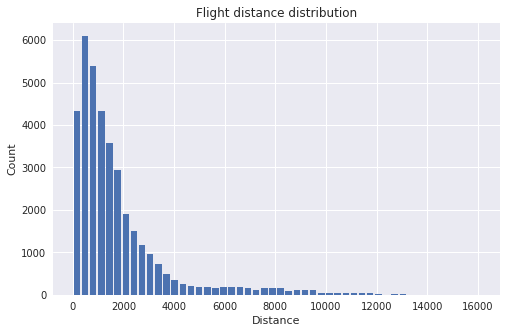

In [251]:
# Visualize the flight distance 
fig = plt.figure(figsize = (8, 5))
ax = fig.add_subplot(111)
_ = ax.hist(x = dists_df["distance"], bins = 50, rwidth = 0.8)
ax.set_title("Flight distance distribution")
ax.set_xlabel("Distance")
ax.set_ylabel("Count")

Notice that most of the flights are short distant, which corresponds to the fact.

## 3.7 Insight of aircraft capability

This section investigates into the usages of different aircrafts. Namely we aimed to figure out which aircraft are mostly used for closed flight and which are for far away ones.

In [632]:
dists_df.head()

,source_airport_id,destination_airport_id,Latitude_src,Longitude_src,Latitude_dst,Longitude_dst,distance
0,2965,2990,43.449902,39.956600,55.606201,49.278702,1507.989680
1,2966,2990,46.283298,48.006302,55.606201,49.278702,1040.943207
2,2968,2990,55.305801,61.503300,55.606201,49.278702,773.126239
3,4029,2990,55.408798,37.906300,55.606201,49.278702,718.084202
4,6156,2990,50.643799,36.590099,55.606201,49.278702,1010.815885


In [633]:
routes.head()

,Unnamed: 0,airline,airline_id,source_airport,source_airport_id,destination_airport,destination_airport_id,codeshare,stops,equipment
0,0,2B,410,AER,2965,KZN,2990,NaN,0,CR2
1,1,2B,410,ASF,2966,KZN,2990,NaN,0,CR2
2,2,2B,410,ASF,2966,MRV,2962,NaN,0,CR2
3,3,2B,410,CEK,2968,KZN,2990,NaN,0,CR2
4,4,2B,410,CEK,2968,OVB,4078,NaN,0,CR2


In [642]:
# Create dataframe of aircraft and avg distance covered in one flight
aircraft_dists = dists_df.merge(routes,
                               left_on = ["source_airport_id", "destination_airport_id"],
                               right_on = ["source_airport_id", "destination_airport_id"])
aircraft_dists = aircraft_dists[["distance", "equipment"]]

In [648]:
# Create dataframe of long distance aircrafts and short ones
long_dist_aircrafts = aircraft_dists.groupby("equipment")\
                                    .filter(lambda g: len(g) > 10)\
                                    .groupby("equipment")\
                                    .mean()\
                                    .sort_values("distance", ascending = False)[: K]
short_dist_aircrafts = aircraft_dists.groupby("equipment")\
                                    .filter(lambda g: len(g) > 10)\
                                    .groupby("equipment")\
                                    .mean()\
                                    .sort_values("distance", ascending = True)[: K]

In [651]:
print(f"The {K} aircrafts with longest distance covered in one flight")
long_dist_aircrafts

The 10 aircrafts with longest distance covered in one flight


,distance
equipment,
380,10949.741248
77L,9234.080876
346,9127.440616
77W 772,8944.357927
772 77W,8744.299395
74H,8523.223998
74M,8060.177432
787,7984.452372
345 346,7943.698502


In [650]:
print(f"The {K} aircrafts with shortest distance covered in one flight")
short_dist_aircrafts

The 10 aircrafts with shortest distance covered in one flight


,distance
equipment,
BH2,51.494244
DHP,54.009243
BNI,74.682626
YN2,96.647737
PAG,117.165917
DH2 DH1,138.886873
DH1 DH2,141.011146
CNA,141.232879
BEC,150.973231
